# Classification multi


In [1]:
%reset -f

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
np.set_printoptions(linewidth=500,precision=2,suppress=True)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
torch.set_default_device("cuda")

##  MNIST data



### import data

70 000 images de 28*28 pixel écrite à la main, représentant des chiffres à retrouver.

C'est le "Hello world" du machine learning.



In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train)
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test)

In [ ]:
#data are classical images
X_train.shape,y_train.shape,X_train.dtype,y_train.dtype

In [ ]:
torch.unique(X_test)

Effectuons une normalisation des données

In [ ]:
# on préfére des floatant dans l'intervalle [0,1]
X_train=X_train/255
X_test=X_test/255
X_train.dtype,X_test.dtype

In [ ]:
plt.imshow(X_train[0,:,:].cpu());

### Les labels

In [ ]:
"""the data are randomized"""
print(y_train[:50])

Oula, des `uint8`. Dangeureux. On les convertit en int68 (le dtype par défaut pour les entier torch)

In [ ]:
y_train=y_train.to(torch.int64)
y_test=y_test.to(torch.int64)

In [ ]:
"almost the same instance number for each digit"
val,count=np.unique(y_train.cpu(),return_counts=True)
plt.bar(val,count);
plt.xticks(val);

In [ ]:
def plot_Xy(X,y):
    ni=5
    nj=5
    fig,axs=plt.subplots(ni,nj,figsize=(2*nj,2*ni))
    for i in range(ni):
        for j in range(nj):
            k=i*nj+j
            axs[i,j].imshow(X[k,:,:].cpu())
            axs[i,j].set_title(f"{y[k].detach().cpu().numpy()}")
            axs[i,j].axis("off")

    fig.tight_layout()

plot_Xy(X_train,y_train)

## Tout pour l'entrainement


### Distributeur de batch

In [ ]:
"""  distributeur de donnée par batch.   """
def oneEpoch(X_all,Y_all,batch_size):

    nb_batches=len(X_all)//batch_size

    shuffle_index=np.random.permutation(len(X_all))
    X_all_shuffle=X_all[shuffle_index]
    Y_all_shuffle=Y_all[shuffle_index]

    for i in range(nb_batches):
        yield X_all_shuffle[i*batch_size:(i+1)*batch_size],Y_all_shuffle[i*batch_size:(i+1)*batch_size]

In [ ]:
for x,y in oneEpoch(X_train,y_train,10_000):
    print(x.shape,y.shape)

### Agent

In [ ]:
import copy
class Agent:

    def __init__(self,model,learning_rate,X_train,Y_train,batch_size,loss_fn):
        self.loss_fn = loss_fn
        self.model = model
        self.batch_size=batch_size
        nb_data_train=int(len(X_train)*0.8)
        self.X_train=X_train[:nb_data_train]
        self.Y_train=Y_train[:nb_data_train]
        self.X_val=X_train[nb_data_train:]
        self.Y_val=Y_train[nb_data_train:]


        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.losses=[]
        self.val_steps=[]
        self.val_losses=[]
        self.step_count=-1


    def train_step(self,x,y):
        pred = self.model(x)
        loss = self.loss_fn(pred,y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss


    def val_step(self,x,y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fn(pred,y)
        return loss


    def train(self,nb_epochs):
        for _ in range(nb_epochs):
            for x,y in oneEpoch(self.X_train,self.Y_train,self.batch_size):
                self.step_count+=1
                loss=self.train_step(x,y)
                self.losses.append(loss.detach().cpu().numpy())

            val_loss=self.val_step(self.X_val,self.Y_val).cpu().numpy()
            self.val_losses.append(val_loss)

            if val_loss<=np.min(self.val_losses):
                print(f"⬊{val_loss:.3g}",end="")
                self.best_weights=copy.deepcopy(self.model.state_dict())
            else:
                print("⬈",end="")

            self.val_steps.append(self.step_count)

    def set_model_at_best(self):
        self.model.load_state_dict(self.best_weights)

##  Classification  Multi-classe

On va chercher à retrouver les labels à partir des images applaties.

### Images applaties

Nous transformons chacune des images 2D un vecteur 1D

In [ ]:
X_train_flat=X_train.reshape([-1,28*28])
X_test_flat=X_test.reshape([-1,28*28])

X_train_flat.shape

Traçons pleins d'images applaties, en les regroupant par label:

In [ ]:
def plot_one_label(label):
    X_train_one=X_train_flat[y_train==label]
    X_train_one=X_train_one[:200]
    plt.matshow(X_train_one.cpu())
    print(X_train_one.shape)

In [ ]:
plot_one_label(0)

In [ ]:
plot_one_label(1)

In [ ]:
plot_one_label(2)

On voit que même toute applaties, chaque label donne un signal avec un aspect assez particulier.

### Modèle

Mais on va créer un modèle qui fera lui même le travail d'applatissage. Ainsi il mangera des images.

#### ♡♡

In [ ]:
class Model_classif(torch.nn.Module):
    def __init__(self,hidden_dim=64):
        super().__init__()
        ...

    def forward(self, x):
        x=x.reshape([-1,784])
        ...

def test():
    model=Model_classif(64)
    Y_pred=model(X_train[:20])
    print(Y_pred.shape)
test()

### La loss

Colons la crossentropy à la main pour être certain d'avoir compris.

Commençons par voir comment sélectionner les éléments par indice:



In [ ]:
y_pred_logits=torch.rand([4,2])
y_pred_logits

In [ ]:
y_true=torch.tensor([0,1,1,0])

In [ ]:
y_pred_logits[torch.arange(4),y_true]

In [ ]:
def my_sparse_cross_entropy_from_logits(y_pred_logits,y_true):
    y_pred_proba=torch.softmax(y_pred_logits,dim=1)
    each=torch.arange(len(y_pred_proba))
    selected=y_pred_proba[each,y_true]
    return torch.mean(-torch.log(selected))

In [ ]:
my_sparse_cross_entropy_from_logits(y_pred_logits,y_true)

In [ ]:
scel_torch=torch.nn.CrossEntropyLoss()
scel_torch(y_pred_logits,y_true)

Youpi, on a le même résultat que torch en personne.

### Entrainement

In [ ]:
model=Model_classif(64)
agent=Agent(model,1e-3,X_train,y_train,256,torch.nn.CrossEntropyLoss())

In [ ]:
agent.train(30)

### Calcul de l'accuracy

#### ♡♡

Complétez le calcul de l'accuracy

In [ ]:
agent.set_model_at_best()

In [ ]:
y_pred_logits=
y_pred=
y_pred.shape

In [ ]:
#--- To keep following outputs, do not run this cell! ---

torch.Size([10000])

Contrairement à numpy il faut faire un cast pour transformer les True/False en 1/0

In [ ]:
torch.mean((y_pred==y_test).to(torch.float32))

In [ ]:
#--- To keep following outputs, do not run this cell! ---

tensor(0.9670, device='cuda:0')

##  Analyse de l'erreur

Bien sur, dans un projet complet de machine learning il faut:

* Tester différentes préparation des données (resclaling, ACP, suppression de valeurs abhérentes ...)

* Essayez différents modèles

* Garder les plus prometteurs

* ajuster les paramètres et sélectionner le modèle avec de la cross-validation et des recherche en grille ou aléatoire.

Et tout l'art est de trouver le bon compromis entre:

* tout automatiser (et risquer de mal comprendre les choses)
* tout faire à la main (et y passer toutes ses nuits)

Supposons que l'on a déjà choisi des modèles prometteurs. On aimerait analyser leur erreurs "à la main" pour tenter de les améliorer.

En premier lieu, il faut regarder la matrice de confusion

### Matrice de confusion

* Chaque ligne représente une vraie étiquette (`y_true`).
* Chaque colonne représente une étiquette prédite (`y_pred`)

Par exemple, sur la classification des chiffres, un modèle entrainé devrait donner ceci:

    [[ 965    0    1    1    0    1    3    3    4    2]
    [   0 1115    3    1    0    1    5    2    8    0]
    [   6    1  998    6    5    3    5    5    3    0]
    [   1    1   10  969    2   13    0    9    3    2]
    [   1    0    9    1  938    1    3    5    2   22]
    [   5    1    2   19    0  846    5    5    5    4]
    [   9    3    2    0    9   12  922    0    1    0]
    [   1    7   14    5    1    0    0  992    0    8]
    [   6    2    5   12    8   11    6    7  915    2]
    [   5    7    0    9   14    6    1   12    4  951]]

La lib `sklearn` permet de la calculer en une ligne:


    conf_mx = sklearn.metrics.confusion_matrix(y_test, y_pred)

Mais c'est aussi très facile à coder à la main.

***A vous:*** Faites un petit programme qui calcul cette matrice de confusion. C'est un bon exercice de programmation. Vous pouvez le faire  avec numpy ou avec torch, c'est quasi pareil.

Pour faire apparaitre des proportions: on divise chacune des valeurs par le nombre d'image dans la classe correspondante. ça devrait donner un truc comme ceci:

    [[0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
    [0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.  ]
    [0.01 0.   0.97 0.01 0.   0.   0.   0.   0.   0.  ]
    [0.   0.   0.01 0.96 0.   0.01 0.   0.01 0.   0.  ]
    [0.   0.   0.01 0.   0.96 0.   0.   0.01 0.   0.02]
    [0.01 0.   0.   0.02 0.   0.95 0.01 0.01 0.01 0.  ]
    [0.01 0.   0.   0.   0.01 0.01 0.96 0.   0.   0.  ]
    [0.   0.01 0.01 0.   0.   0.   0.   0.96 0.   0.01]
    [0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.94 0.  ]
    [0.   0.01 0.   0.01 0.01 0.01 0.   0.01 0.   0.94]]



En notant $\imath$ les vraie instances de la $i$ème-classe et $\hat \imath$ les instances prédites dans cette même classe, nous avons tracé la matrice dont les coefficients sont:
$$
\frac {\imath \cap \hat \jmath}{\imath}
$$
Ainsi on a affiché une proportion qui, en classification binaire, s'appellerait:

* le rappel ?
* la précision ?



### En couleur



In [ ]:
def plot_mat(conf_mx):
    plt.matshow(conf_mx)
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.grid(False)
    plt.colorbar()

Le problème c'est que la diagonale est très dominante. Astuce: mettez à zéro les coefficients diagonnaux pour mieux voir les non-diagonnaux. ça donnera un truc comme ceci:

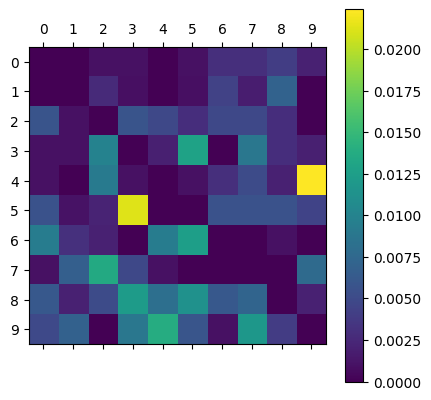

### En couleur et en nombre



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=True,
                          suppress_diag=False,
                          title="",
                          cmap="jet",
                          precision=3,
                         ):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)
    np.set_printoptions(precision=precision)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes=range(cm.shape[0])

    #print("Confusion matrix, without normalization:")
    #print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
        #print(cm)

    if suppress_diag:
        for i in range(len(classes)):
            cm[i,i]=0


    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()
    #fig.savefig(DIR_OUT+"/"+title)

In [ ]:
plot_confusion_matrix(y_test.cpu().numpy(),y_pred.cpu().numpy(),suppress_diag=True)


***A vous:*** Quels sont les chiffres que le modèle confond le plus ? Est-ce qu'il y a une certaine symétrie dans la confusion ?

Que peut-on faire

* rassembler plus de données correspondant à ces classes

* créer des features particulière qui permettent de les distinguer: ex: compter le nombre de composante connexe du complémetaire, ce qui différentie le 8, le 9, et le 5. Mais là on sort un peu du machine learning pour revenir aux algos classiques.

* Observer individuellement les erreurs pour voir s'il n'y a pas de problèmes d'étiquette, de valeurs abhérentes, des problèmes de normalisation etc.



### Observation individuelle des erreurs

***A vous:*** Que fait le programme suivant ? Testez-le avec des chiffre  confondus fréquemment par le modèle.

In [ ]:
def see_confusions(class_true,class_pred,X,y_true,y_pred):
    X_ab = X[(y_true == class_true) & (y_pred == class_pred),:,:]
    print(X_ab.shape)

    fig,axs=plt.subplots(4,4,figsize=(10,10))
    axs=axs.flatten()
    for i,ax in enumerate(axs):
        if i>= len(X_ab):
            break
        ax.imshow(X_ab[i,:,:].cpu())
        ax.axis("off")

In [ ]:
see_confusions(8,3,X_test,y_test,y_pred)

In [ ]:
see_confusions(5,3,X_test,y_test,y_pred)

In [ ]:
see_confusions(3,5,X_test,y_test,y_pred)

##  Classification Multilabel

Parfois on doit poser plusieurs étiquettes sur une même donnée. ex:

* Une donnée = une photo avec plusieur visage. Les étiquettes:  "présence d'un homme", "présence d'une femme".  
* Une donnée = une photo avec 1 animal. Les étiquettes:  mamifère, insecte, lion, chat, mouche: ce sont des catégories non-disjointes.


###  Création des données

In [ ]:
def make_multi_label(y):
    y_large = (y >= 7).to(torch.float32)
    y_odd = (y % 2 == 1).to(torch.float32)
    y_prime = ((y==3)|(y==5)|(y==7)).to(torch.float32)

    y_multilabel = torch.stack([y_large, y_odd,y_prime],dim=1)
    return y_multilabel

y_multi_train=make_multi_label(y_train)
y_multi_test=make_multi_label(y_test)

print(y_multi_train[:10])

* La première colonne indique si un nombre est grand (7, 8, or 9)
* La seconde colonne indique si un nombre est impair
* La troisième colonne indique si un nombre est premier

Remarquons que dans le problème précédent l'output `Y` était un simple vecteur d'entier (car on utilisait la Sparce-cross-entropy-from-logits).

Si on n'avait pas utilisé la version 'sparse' de la cross entropy, l'ouput aurait été une matrice (ce qui est plus naturel en fait).


Pour la situation actuel, l'output est aussi une matrice dont chaque ligne est composée d'un vecteur de tailles 2 composés de 0 ou de 1 (il n'y a pas d'astuce 'sparse' possible).   


In [ ]:
for x,y in oneEpoch(X_train_flat,y_multi_train,10_000):
    print(x.shape,y.shape)

### La loss spécifique

In [ ]:
def mean_binary_crossentropy(y_pred,y_true):
    return torch.mean(-y_true*torch.log(y_pred+1e-10)-(1-y_true)*torch.log((1-y_pred)+1e-10))



def test():
    print(mean_binary_crossentropy(torch.tensor([[1.,1]]),torch.tensor([[1.,1]])))
    print(mean_binary_crossentropy(torch.tensor([[0.,0]]),torch.tensor([[0.,0]])))
    print(mean_binary_crossentropy(torch.tensor([[1.,0]]),torch.tensor([[1.,1]])))
    print(mean_binary_crossentropy(torch.tensor([[0.,0]]),torch.tensor([[1.,1]])))


test()

### Le modèle had hoc

In [ ]:
class Model_classif_multi_label(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        ...

    def forward(self, x):
        x=x.reshape([-1,784])
        #attention à l'activation finale!!!
        ...

X=X_train_flat[:10,:]
model=Model_classif_multi_label(64)
Y_pred=model(X)
print(Y_pred.shape)
print(y_multi_train[:10,:].shape)


### Entrainement

In [ ]:
agent=Agent(Model_classif_multi_label(64),1e-3,X_train,y_multi_train,256,mean_binary_crossentropy)

In [ ]:
agent.train(20)

### Exploitation

In [ ]:
agent.set_model_at_best()

In [ ]:
y_multi_pred=agent.model(X_test_flat)
y_multi_pred

In [ ]:
y_multi_pred=(y_multi_pred>0.5).to(int)
y_multi_pred

Calculons l'accuracy. Mais qu'est-ce que cela signifie dans un cadre multi-lable. Je vois déjà deux variante:

La variante gentille:

In [ ]:
torch.mean((y_multi_pred==y_multi_test).to(torch.float32))

La variante sévère:

In [ ]:
both=(y_multi_pred[:,0]==y_multi_test[:,0])&(y_multi_pred[:,0]==y_multi_test[:,0])
torch.mean(both.to(torch.float32))

#### ♡

***A vous:*** Tranduisez en quelques mots ce que j'entend par 'gentille' et 'sévère'.

##  Classification  Multi-output

Cela regroupe toutes les notions où l'output `Y` est "complexe".



* Exemple 1: `X` est une image et `Y` est aussi une image, de même résolution que `X`. Et `Y[i,j] = 0,1,2,3` selon si `X[i,j]` est un pixel de route, de maison, d'humain, d'arbre. On dit que `Y` est une segmentation de `X`


* Exemple 2: `X` est une image prise par un véhicule. `Y` est un couple contenant une segmentation de `X` et d'une variable indiquant si notre véhicule peut avancer.

* Exemple 3: L'exemple 'multi-label' précédent pouvait aussi être vu comme un multi-output: nous donnions 3 sorties, chacune d'elle décrivant une propriété arithmétique.






L'exemple que l'on va traiter est proche de l'exemple 1 (segmentation d'image).

 L'input `X` est une image MNIST bruité, l'output `Y` est l'image  débruité.


### Créons les données


In [ ]:
def add_noise(X):
    noise = torch.rand(len(X),28,28)*2
    noise2= 0.9*((torch.rand(len(X),28,28)<0.2).to(torch.float32))
    return X+noise+noise2

X_train_mo=add_noise(X_train)
X_test_mo=add_noise(X_test)

#les étiquettes, c'est le images non bruitées, binarisées = chaque pixel peut appartenir à la  classe 0 ou à la classe 1
Y_train_mo=(X_train>0).to(torch.float32)
Y_test_mo=(X_test>0).to(torch.float32)

In [ ]:
def plot_imgs(imgs_list,labels):
    ni=len(imgs_list)
    nj=10

    fig,axs=plt.subplots(ni,nj,figsize=(nj*2,ni*2))
    for i,imgs in enumerate(imgs_list):
        for j in range(nj):
            axs[i,j].imshow(imgs[j,:,:].detach().cpu())
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    for i, label in enumerate(labels):
        axs[i,0].set_ylabel(label)


In [ ]:
plot_imgs([X_train_mo,Y_train_mo],["input","output"])


 Remarque: les images MNIST qui constitue l'output ont été seuilée. Chaque pixel ne peut être que blanc ou noir (pas de gris). Cela donne les deux classes pour notre problème de classification multi-output.    




In [ ]:
class Model_classif_multi_output(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        self.lay1=torch.nn.Linear(784,hidden_dim)
        self.lay2=torch.nn.Linear(hidden_dim,hidden_dim)
        self.lay3=torch.nn.Linear(hidden_dim,hidden_dim)
        self.final_layer=


    def forward(self, x):
        #attention à la dernière activation


In [ ]:
def mse(y_pred,y_true):
    return torch.mean((y_pred-y_true)**2)

In [ ]:
model=Model_classif_multi_output(256)
agent=Agent(model,1e-3,X_train_mo,Y_train_mo,256,mean_binary_crossentropy)

In [ ]:
agent.train(30)

In [ ]:
agent.set_model_at_best()

In [ ]:
Y_pred_mo=agent.model(X_test_mo)

In [ ]:
Y_pred_mo_bin=(Y_pred_mo>0.5)

In [ ]:
plot_imgs([X_test_mo,Y_test_mo,Y_pred_mo,Y_pred_mo_bin],["input","output","pred", "pred_bin"])

## Multi à vous

### Variante sur le débruitage


Notre problème de debruitage serait plus naturellement un problème de regression

#### ♡♡♡♡

Créez le modèle et choisissez la bonne loss pour retrouver des images originelle `X_test` (considérer comme des output) à partir des l'input `X_test_mo`

### Un vrai problème pour vous

In [ ]:
def make_multi_label_hard(X,y):
    n=len(X)

    rand_perm=np.random.permutation(n)
    X1=X[rand_perm]
    y1=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X2=X[rand_perm]
    y2=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X3=X[rand_perm]
    y3=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X4=X[rand_perm]
    y4=y[rand_perm]

    Z_haut=torch.concat([X1,X2],dim=1)
    Z_bas=torch.concat([X3,X4],dim=1)
    Z = torch.concat([Z_haut,Z_bas],dim=2)

    yy = torch.stack([y1,y2,y3,y4],dim=1)
    for i in range(n):
        yy[i,:]= torch.sort(yy[i,:])[0]

    return Z,yy

In [ ]:
X_train_mlh,Y_train_mlh=make_multi_label_hard(X_train,y_train)

plot_Xy(X_train_mlh,Y_train_mlh)

#### ♡♡♡♡♡♡♡

Retrouvez au mieux les étiquettes à partir des images.

L'entrainement ne devra pas être long. Le plus gros du travail et de trouver comme "encoder" ces étiquettes.

ººuntil
Et quand je vous disais que les `uint8` sont dangereux:

In [ ]:
# mse=lambda a,b:torch.mean((a-b)**2)

model=Model_classif_multi_label_hard()
agent=Agent(model,1e-3,X_train_mlh,Y_train_mlh_vec,256,cross_entropy)